In [77]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter, maximum_filter, minimum_filter
import xarray as xr

In [78]:
#Plotting Max and Min data points
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == np.array(data))
    
    lon, lat = np.meshgrid(lons, lats)

    for i in range(len(mxy)):
        ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]], symbol, color=color, size=24,
                clip_on=True, clip_box=ax.bbox, horizontalalignment='center', verticalalignment='center',
                transform=transform)
        
        a = np.array(data[mxy[i], mxx[i]])
        a_trunc = np.trunc(a)
        
        ax.text(lon[mxy[i], mxx[i]], lat[mxy[i], mxx[i]],
                '\n' + str(a_trunc),
                color=color, size=12, clip_on=True, clip_box=ax.bbox, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform, 
                zorder=5)

In [79]:
#Open ERA5 dataset; change name accordingly to yours
ds = xr.open_dataset('EU_Single Levels.nc')
ds

<xarray.Dataset>
Dimensions:    (longitude: 141, latitude: 101, time: 72)
Coordinates:
  * longitude  (longitude) float32 105.0 105.2 105.5 105.8 ... 139.5 139.8 140.0
  * latitude   (latitude) float32 25.0 24.75 24.5 24.25 ... 0.75 0.5 0.25 0.0
  * time       (time) datetime64[ns] 2016-08-13 ... 2016-08-15T23:00:00
Data variables: (12/13)
    d2m        (time, latitude, longitude) float32 ...
    cape       (time, latitude, longitude) float32 ...
    cin        (time, latitude, longitude) float32 ...
    cp         (time, latitude, longitude) float32 ...
    z          (time, latitude, longitude) float32 ...
    hcc        (time, latitude, longitude) float32 ...
    ...         ...
    lsp        (time, latitude, longitude) float32 ...
    lcc        (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    mcc        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
    totalx     (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-08-05 08:13:16 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [80]:
#Open another (optional) ERA5 dataset; change name accordingly to yours
ds1 = xr.open_dataset('EU_SL_PrecipSurfWinds.nc')
ds1

<xarray.Dataset>
Dimensions:    (longitude: 141, latitude: 101, time: 24)
Coordinates:
  * longitude  (longitude) float32 105.0 105.2 105.5 105.8 ... 139.5 139.8 140.0
  * latitude   (latitude) float32 25.0 24.75 24.5 24.25 ... 0.75 0.5 0.25 0.0
  * time       (time) datetime64[ns] 2016-08-14 ... 2016-08-14T23:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    tcwv       (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-09-12 07:27:35 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [81]:
# Grab lat/lon values (NAM will be 2D)
lats = ds.latitude
lons = ds.longitude

# Select and grab data
mslp = ds['msl']
uwnd = ds1['u10']
vwnd = ds1['v10']
precip = ds1['tcwv']

# Select and grab MSLP, U and V-components, and Precip. Water. Apply gaussian_filter
mslp_surf = gaussian_filter(mslp.data[30], sigma=3.0) * units.pascal
mslp_hpa = mslp_surf.to(units.hectopascal)

uwnd_surf = gaussian_filter(uwnd.data[6], sigma=3.0) * units('m/s')
vwnd_surf = gaussian_filter(vwnd.data[6], sigma=3.0) * units('m/s')

precip_water = gaussian_filter(precip.data[6], sigma=3.0) * units('kg/m^2')

vtime = datetime.strptime(str(ds1.time.data[6].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

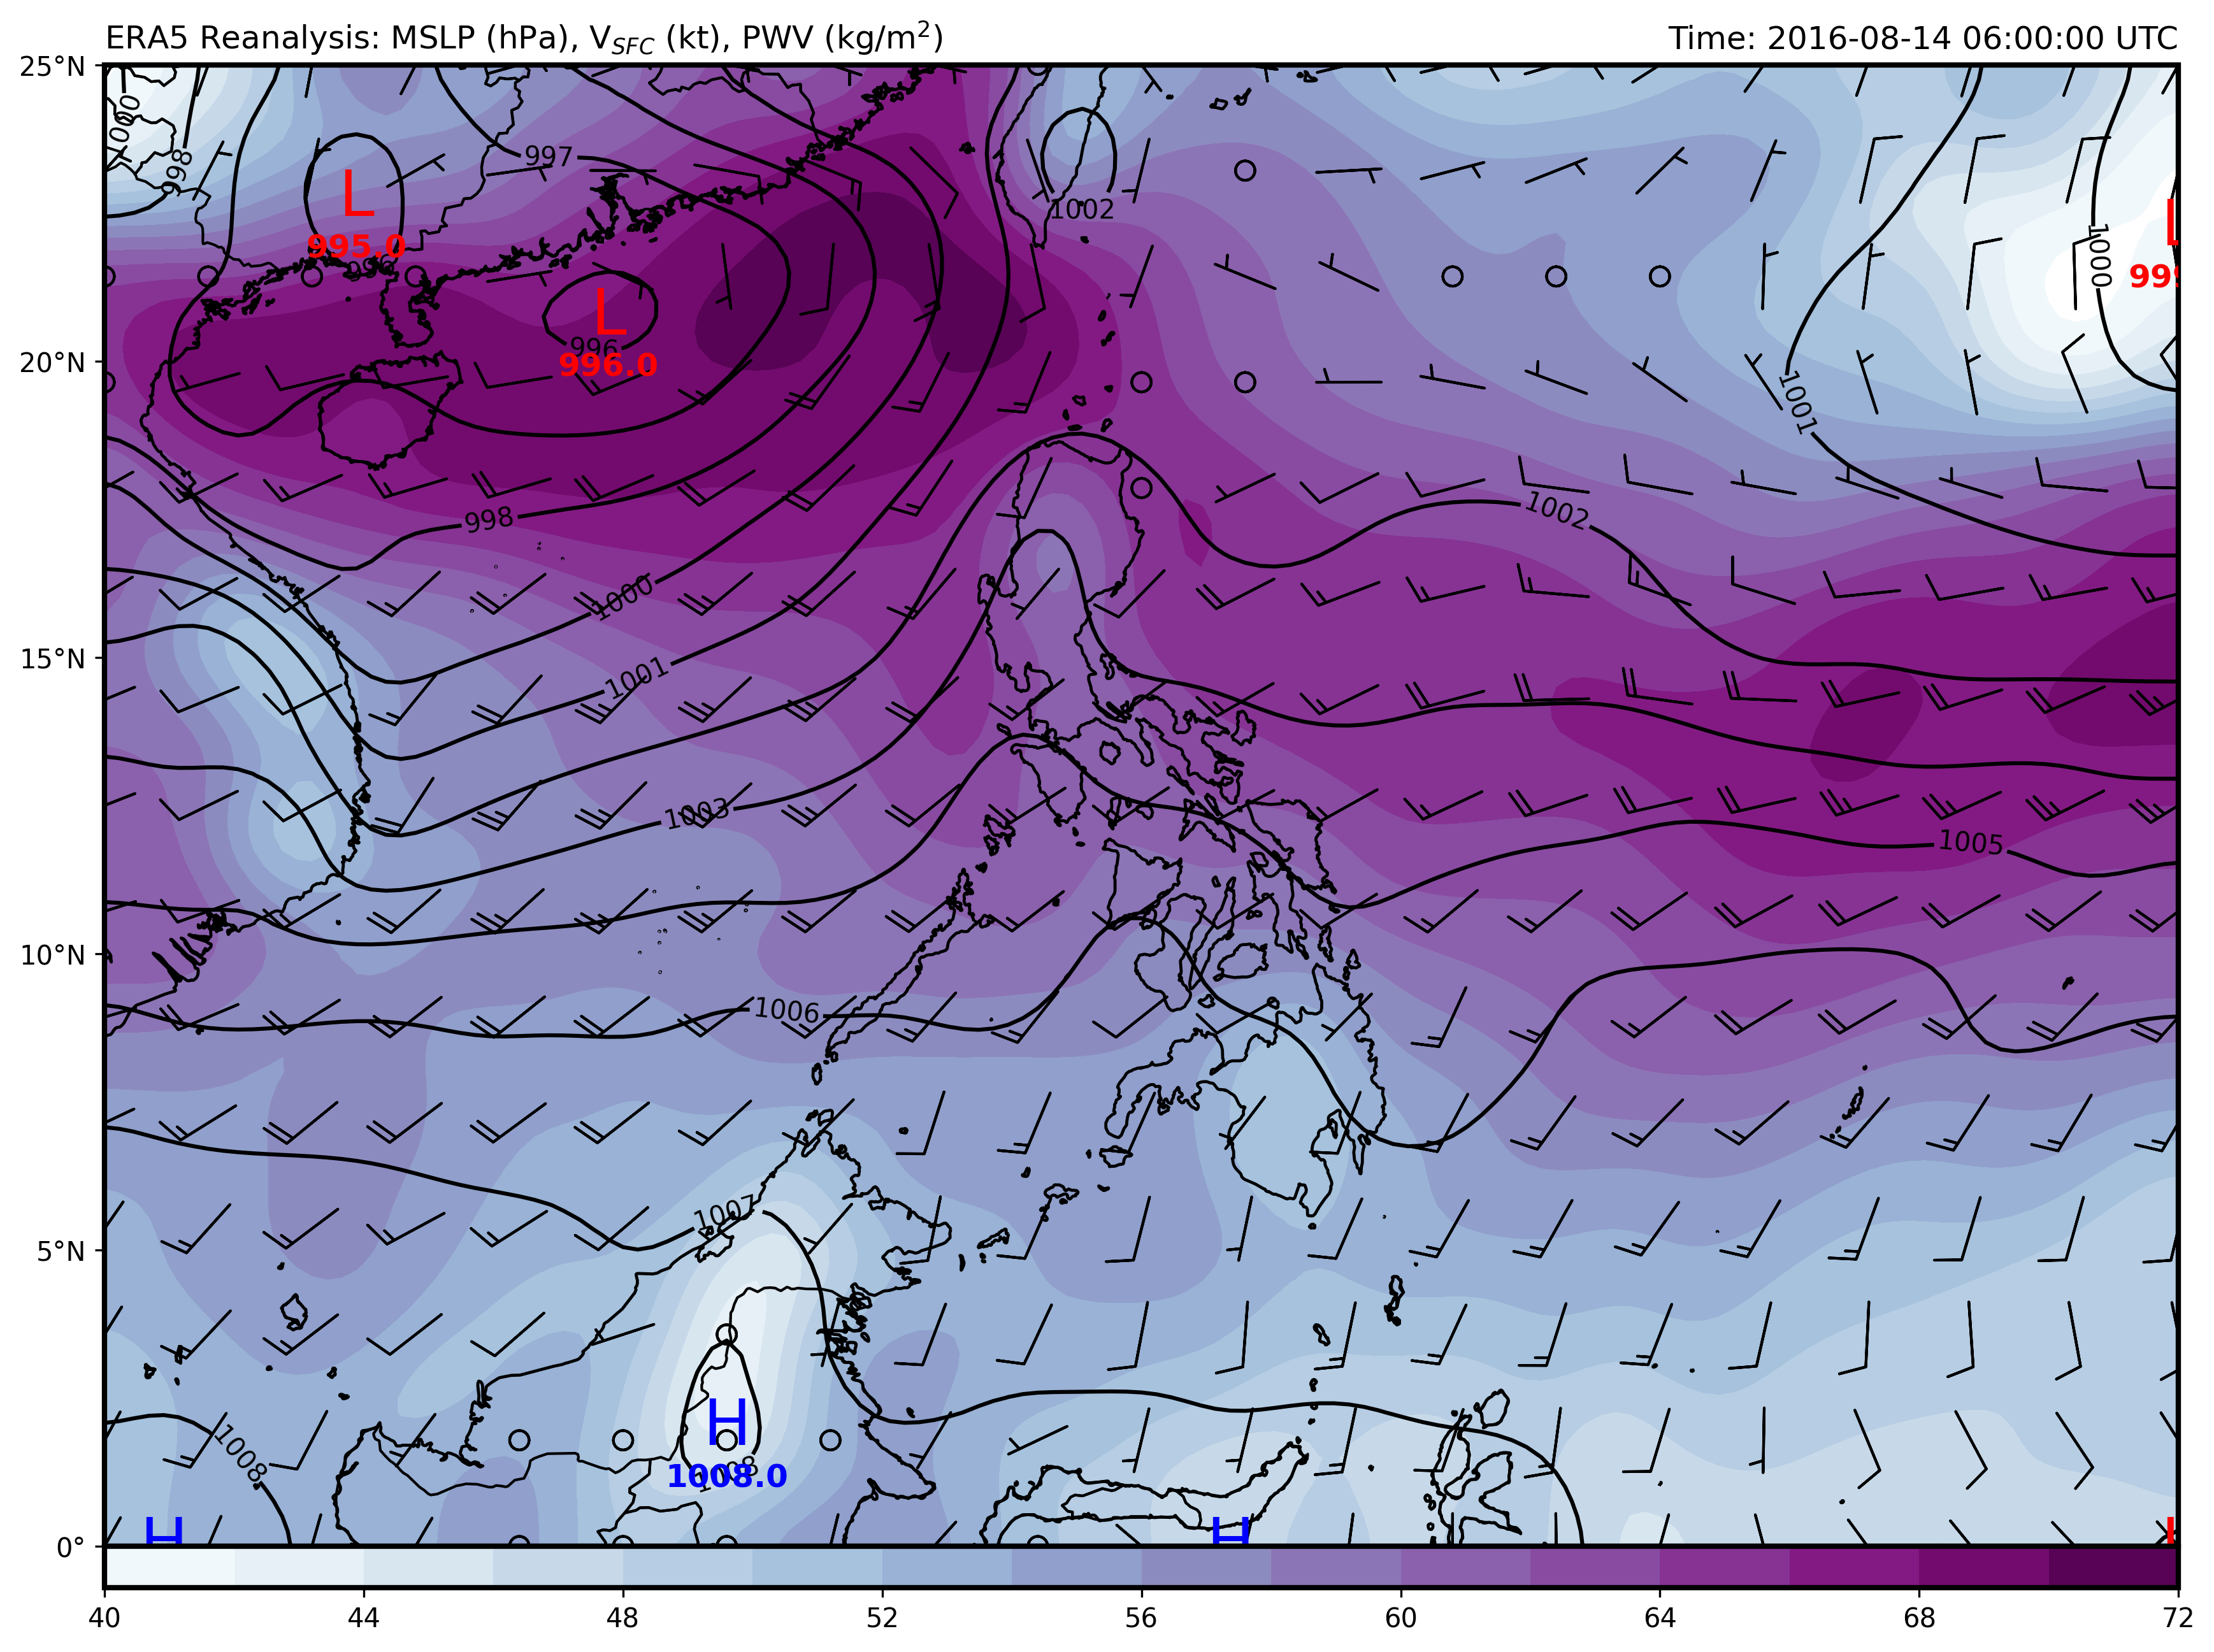

In [82]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.PlateCarree()

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=datacrs)
ax.set_extent([105, 140, 0, 25], mapcrs)

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=1.15)
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot MSLP Contour
MSLP_range = np.arange(995, 1010, 1.25)
prs = ax.contour(lons, lats, mslp_hpa, MSLP_range, colors='k',
                 transform=datacrs)
ax.clabel(prs, fmt='%d')

# Plot Precipitable Water Vapour as contour
precip_limit = np.arange(40, 74, 2)
cf = ax.contourf(lons, lats, precip_water, precip_limit, cmap='BuPu',
                 transform=datacrs)
plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)

# Add Surface Winds using U and V-components
ax.barbs(lons, lats, uwnd_surf.to('kt').m, vwnd_surf.to('kt').m, pivot='middle',
         color='black', regrid_shape=15, transform=datacrs)

# Plot Highs and Lows (Min/Max) values of MSLP
plot_maxmin_points(lons, lats, mslp_hpa, 'max', 60, symbol='H', color='b', transform=datacrs)
plot_maxmin_points(lons, lats, mslp_hpa, 'min', 20, symbol='L', color='r', transform=datacrs)

# Make some nice titles for the plot (one right, one left)
plt.title('ERA5 Reanalysis: MSLP (hPa), V$_{SFC}$ (kt), PWV (kg/m$^{2}$)', loc='left')
plt.title('Time: {} UTC'.format(vtime), loc='right')

# Set Y-ticks for Latitude Coordinates
ax.set_yticks(lats, 5, crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.minorticks_off()

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'
plt.savefig('MSLP, Zsurf, Precip.jpg', bbox_inches="tight")
plt.show()